In [1]:
import copy
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
import autograd.numpy as np
from sklearn import datasets, preprocessing
import pandas as pd
from pymanopt.solvers import TrustRegions
from manopt_dr.core import gen_ldr
from manopt_dr.predefined_func_generator import *
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import os
from scipy.spatial import ConvexHull, convex_hull_plot_2d
from scipy.interpolate import interp1d
import sys
from descartes import PolygonPatch
import alphashape
from skimage.measure import EllipseModel
from matplotlib.patches import Ellipse

In [2]:
# Generate data

dataset = datasets.load_wine()

y = dataset.target
X = dataset.data
n_samples, n_features = X.shape
n_components = 2
X = preprocessing.scale(X)


In [3]:
# generalized cPCA initialization

GCPCA = gen_ldr(gen_cost_gcpca, gen_default_proj)
GCPCA2 = gen_ldr(gen_cost_gcpca2, gen_default_proj)
label_set = [0,1,2]


In [4]:
# Helper functions

def return_partition(my_list):
# return parititons
    filtered=[]
    for l in range(1,len(my_list)):
        for c in itertools.combinations(my_list,l):
            filtered.append(c)
    return filtered

partitions = return_partition(label_set)

def print_groups(groups):
    s = ""
    for g in range(len(groups)):
        if g == len(groups) - 1:
            s += str(groups[g])
        else:
            s += str(groups[g]) + ","
    return s

def print_groups_index(index):
    groups =  partitions[index]
    s = ""
    for g in range(len(groups)):
        if g == len(groups) - 1:
            s += str(groups[g])
        else:
            s += str(groups[g]) + ","
    return s

for p in partitions:
    print(print_groups(p))
    
def encircle_convex(x,y, ax=None, **kw):
    if not ax: ax=plt.gca()
    p = np.c_[x,y]
    hull = ConvexHull(p)
    x = p[hull.vertices, 0]
    y = p[hull.vertices, 1]
    fx = interp1d(range(len(x)), x, kind='cubic')
    fy = interp1d(range(len(y)), y, kind='cubic')
    # generate new x-, y-coords
    n_interp_points = 1000
    x_new = fx(np.linspace(0, len(x) - 1, n_interp_points))
    y_new = fy(np.linspace(0, len(y) - 1, n_interp_points))
    vertices = np.ones(2000).reshape(1000,2)
    vertices[:,0] = x_new
    vertices[:,1] = y_new
    alpha_shape = alphashape.alphashape(vertices, 0.1)

    ax.add_patch(PolygonPatch(alpha_shape, alpha=0.1))


def draw_ellipse(axs,x,y,c):
    
    a_points = np.stack((x, y), axis=1)
    ell = EllipseModel()
    ell.estimate(a_points)
    xc, yc, a, b, theta = ell.params

    ell_patch = Ellipse((xc, yc), 2.5*a, 2.5*b, theta*180/np.pi, edgecolor=c, facecolor='none')

    axs.scatter(xc, yc, color=c, s=50)
    axs.scatter(xc,yc,facecolors='none', edgecolors=c, s = 200)
    axs.add_patch(ell_patch)
    

0
1
2
0,1
0,2
1,2


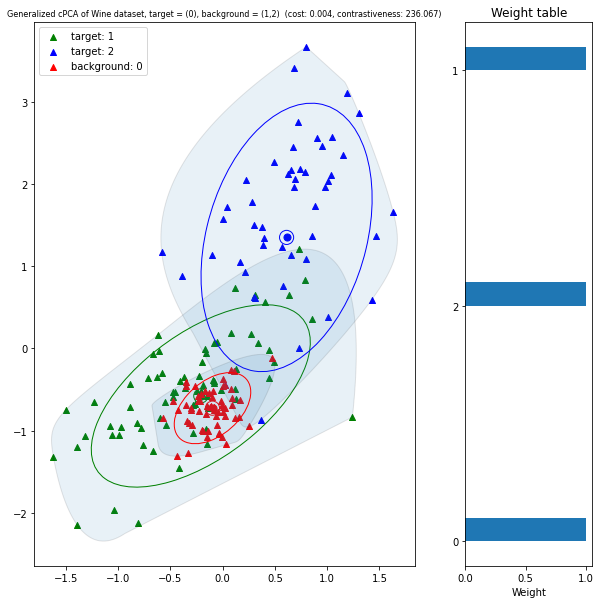

<Figure size 432x288 with 0 Axes>

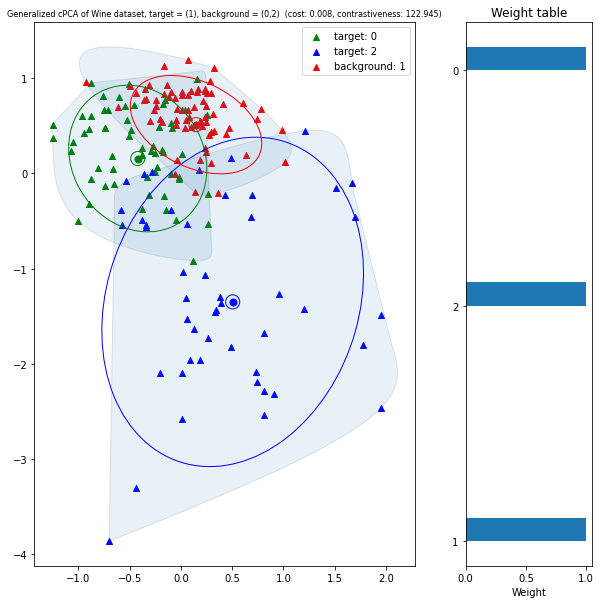

<Figure size 432x288 with 0 Axes>

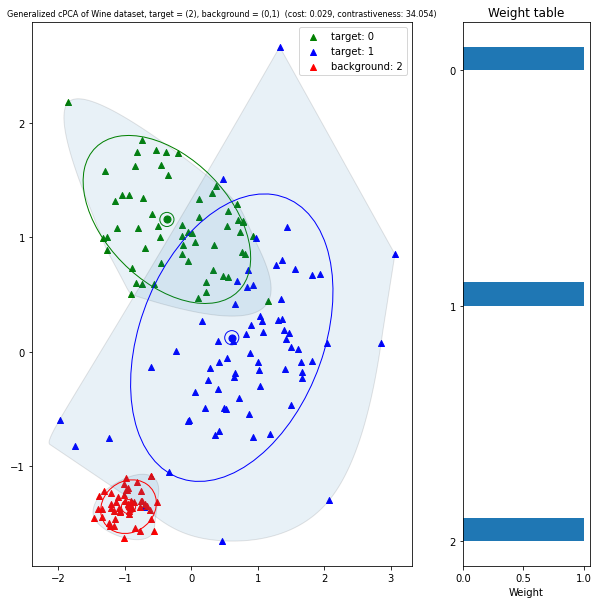

<Figure size 432x288 with 0 Axes>

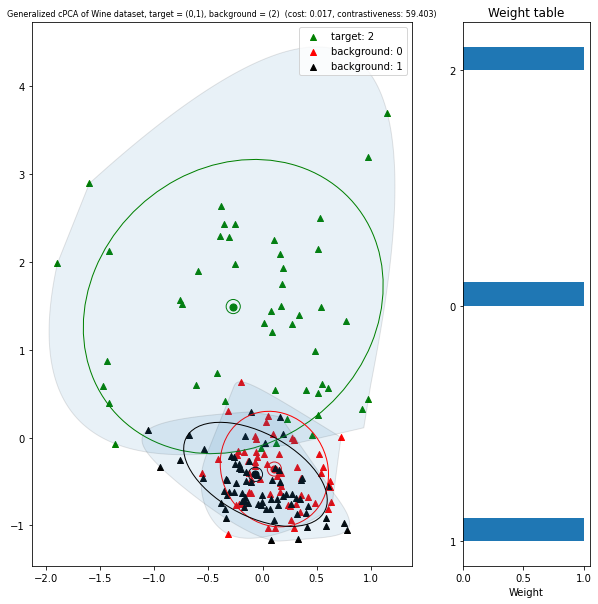

<Figure size 432x288 with 0 Axes>

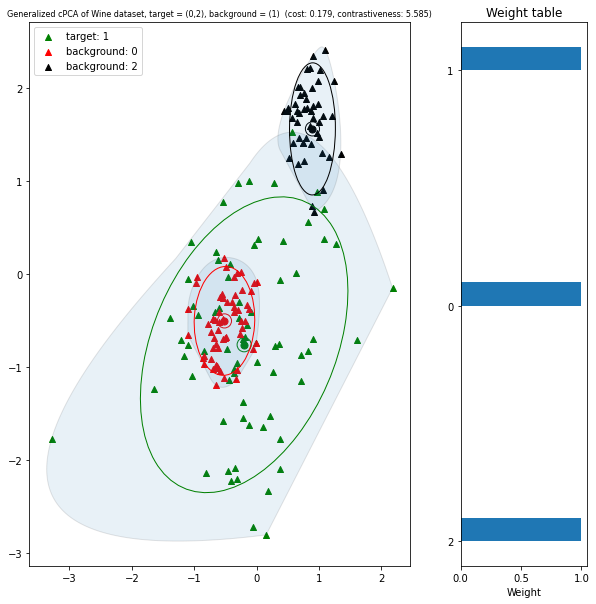

<Figure size 432x288 with 0 Axes>

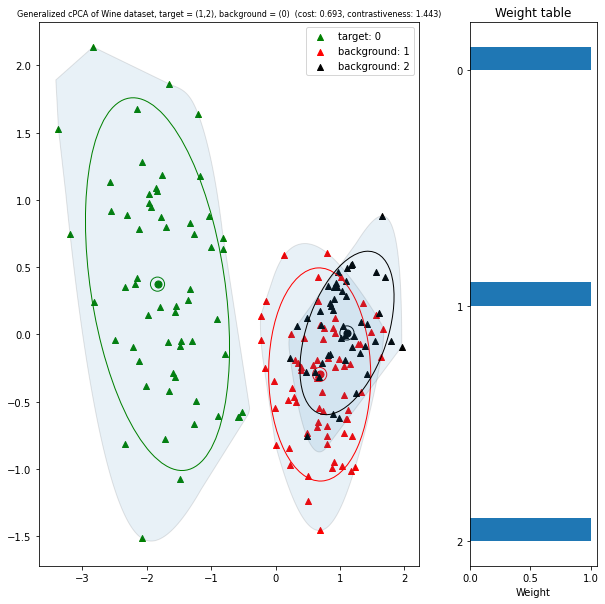

<Figure size 432x288 with 0 Axes>

In [5]:
# With alpha shape
def Trials(g1,g2):    
    
    y_tg = copy.deepcopy(y)
    y_tg = np.asarray(y_tg)

    for i in g1:
        y_tg[y_tg == i] = -1

    y_bg = copy.deepcopy(y)
    y_bg = np.asarray(y_bg)

    for i in g2:
        y_bg[y_bg == i] = -1


    
    w_tg = np.ones(y_tg.shape)
    w_bg = np.ones(y_bg.shape)
    w_bw = np.ones(y.shape)
    w_tg[y_tg == 2] = 5
    w_bw[y == 1] = 5
    gcpca2 = GCPCA2(n_components=n_components).fit(X,
                                               y_tg=y_tg,
                                               y_bg=y_bg,
                                               y_bw=y,
                                               w_tg=w_tg,
                                               w_bg=1,
                                               w_bw=0)
    Z = gcpca2.transform(X)
    cost = gcpca2.get_final_cost()
    contrastiveness = 1 / cost

    # Plot
    fig, (ax1, ax2) = plt.subplots(1, 2,figsize = (10,10),gridspec_kw={'width_ratios': [3, 1]})
    
    # The target has the maximum variance

    g1,g2 = g2,g1
    

    # target label color candidates 
    c_tg = ['g','b']
    
    # background label color candidates
    c_bg = ['r','black','pink']

    for g in g1:
        encircle_convex(Z[y==g,0],Z[y==g,1],ax = ax1,ec="k",fc="pink",alpha = 0.3)
        tg_x = [Z[i][0] for i in range(len(y)) if y[i] == g]
        tg_y = [Z[i][1] for i in range(len(y)) if y[i] == g]
        ax1.scatter(tg_x, tg_y, marker='^',label = "target: " + str(g), color=c_tg[g1.index(g)])
        draw_ellipse(ax1,Z[y==g,0],Z[y==g,1],c_tg[g1.index(g)])
    
    for g in g2:
        encircle_convex(Z[y==g,0],Z[y==g,1],ax = ax1,ec="k",fc="#7dc8e5",alpha = 0.3)
        bg_x = [Z[i][0] for i in range(len(y)) if y[i] == g]
        bg_y = [Z[i][1] for i in range(len(y)) if y[i] == g]
        ax1.scatter(bg_x, bg_y, marker='^',label = "background: " + str(g), color=c_bg[g2.index(g)])
        draw_ellipse(ax1,Z[y==g,0],Z[y==g,1],c_bg[g2.index(g)])
    
    ax1.legend(loc='best', shadow=False, scatterpoints=1)
    ax1.set_title(
        f'Generalized cPCA of Wine dataset, target = ({print_groups(g2)}), background = ({print_groups(g1)})  (cost: {cost:.3f}, contrastiveness: {contrastiveness:.3f})',fontsize = 8)
    
    # Weight table: not yet finished
    y_pos = np.arange(len(g1)+len(g2))
    ax2.barh(y_pos, np.repeat(1,len(g1)+len(g2)), height = -0.1,align = 'edge')
    ax2.set_yticks(y_pos)
    ax2.set_yticklabels(np.hstack((g1, g2)))
    ax2.invert_yaxis()  # labels read top-to-bottom
    ax2.set_xlabel('Weight')
    ax2.set_title('Weight table')
    
    plt.savefig(f'{print_groups(g2)} - {print_groups(g1)}_alpha.png')
    plt.show()
    plt.clf()
    
    return contrastiveness

map_dataset = []
for i in range(len(partitions)):
    row = []
    rec = [l for l in label_set if l not in partitions[i]]
    c = Trials(partitions[i],rec)
    row = [ list(partitions[i]), rec ,c]
    map_dataset.append(row)



In [6]:
"""
columns = [("T : {" + print_groups(x[0]) +  "}",  "B : {" + print_groups(x[1]) + "}") for x in map_dataset]
values = [round(x[2],6) for x in map_dataset]

columns.insert(0," ")
values.insert(0,"Contrast")


fig = go.Figure(data=[go.Table(header=dict(values = columns, align = "left",   font=dict(color='white', size=12)),
                 cells=dict(values = values))
                              ])
fig.write_image("Table.png")
import csv
print("Contrastiveness")
row_list = [["Target and Background set", "Contrastiveness"]]
for i in range(len(columns)):
    row_list.append([columns[i] ,values[i]])

with open('Wine_combinations.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(row_list)
"""

'\ncolumns = [("T : {" + print_groups(x[0]) +  "}",  "B : {" + print_groups(x[1]) + "}") for x in map_dataset]\nvalues = [round(x[2],6) for x in map_dataset]\n\ncolumns.insert(0," ")\nvalues.insert(0,"Contrast")\n\n\nfig = go.Figure(data=[go.Table(header=dict(values = columns, align = "left",   font=dict(color=\'white\', size=12)),\n                 cells=dict(values = values))\n                              ])\nfig.write_image("Table.png")\nimport csv\nprint("Contrastiveness")\nrow_list = [["Target and Background set", "Contrastiveness"]]\nfor i in range(len(columns)):\n    row_list.append([columns[i] ,values[i]])\n\nwith open(\'Wine_combinations.csv\', \'w\', newline=\'\') as file:\n    writer = csv.writer(file)\n    writer.writerows(row_list)\n'

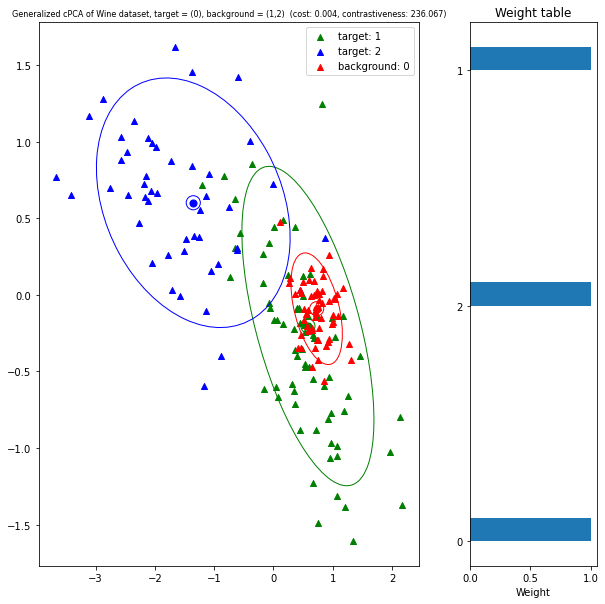

<Figure size 432x288 with 0 Axes>

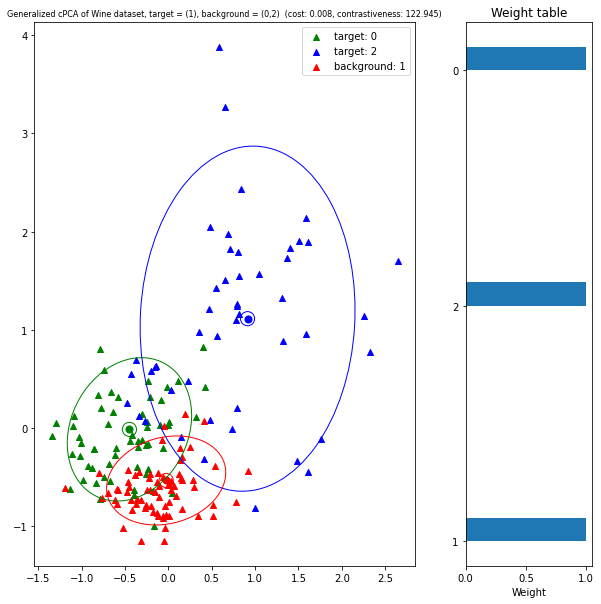

<Figure size 432x288 with 0 Axes>

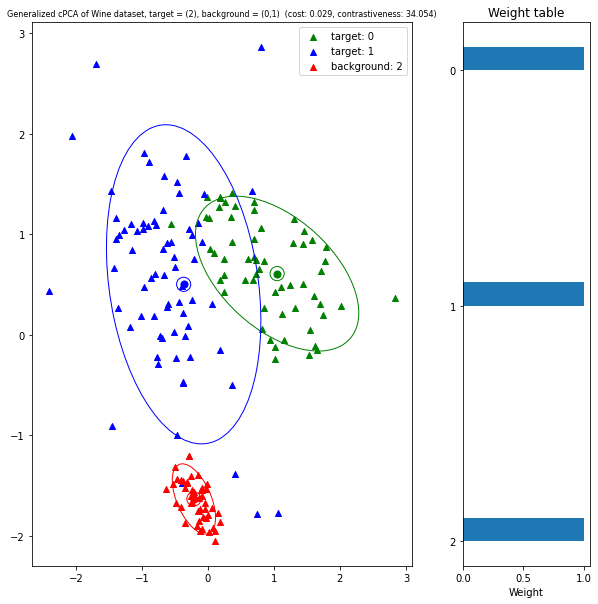

<Figure size 432x288 with 0 Axes>

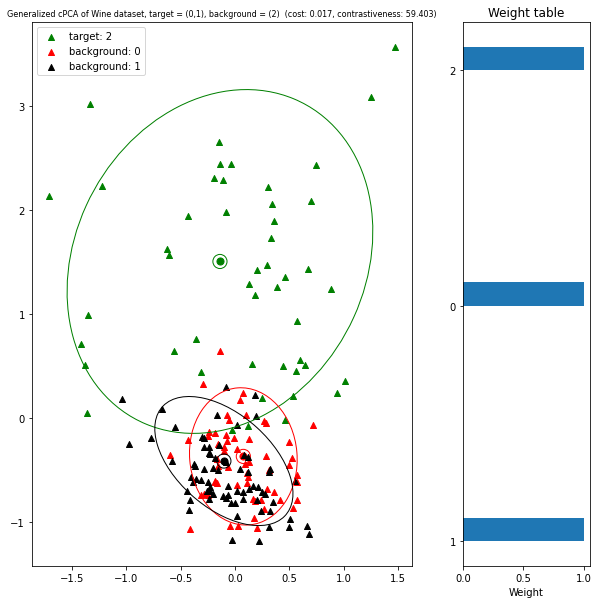

<Figure size 432x288 with 0 Axes>

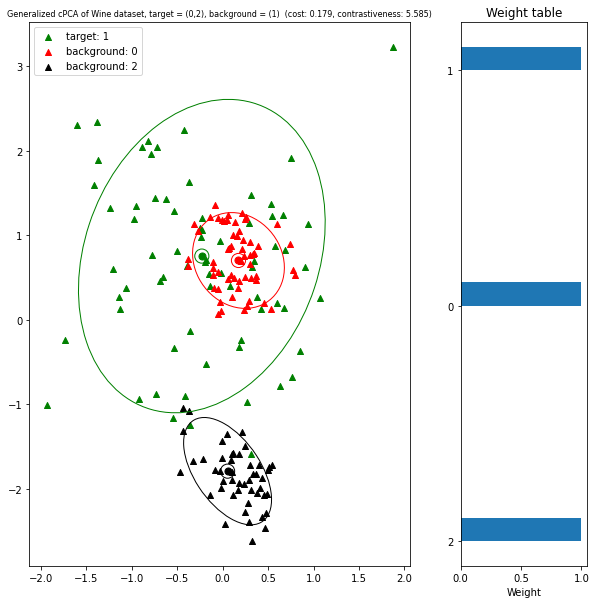

<Figure size 432x288 with 0 Axes>

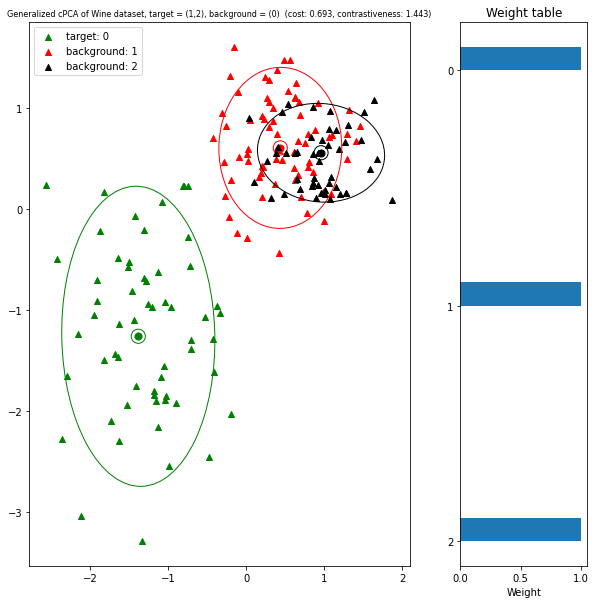

<Figure size 432x288 with 0 Axes>

In [7]:
# Without alphashape
    
def Trials(g1,g2):    
    
    y_tg = copy.deepcopy(y)
    y_tg = np.asarray(y_tg)

    for i in g1:
        y_tg[y_tg == i] = -1

    y_bg = copy.deepcopy(y)
    y_bg = np.asarray(y_bg)

    for i in g2:
        y_bg[y_bg == i] = -1


    
    w_tg = np.ones(y_tg.shape)
    w_bg = np.ones(y_bg.shape)
    w_bw = np.ones(y.shape)
    w_tg[y_tg == 2] = 5
    w_bw[y == 1] = 5
    gcpca2 = GCPCA2(n_components=n_components).fit(X,
                                               y_tg=y_tg,
                                               y_bg=y_bg,
                                               y_bw=y,
                                               w_tg=w_tg,
                                               w_bg=1,
                                               w_bw=0)
    Z = gcpca2.transform(X)
    cost = gcpca2.get_final_cost()
    contrastiveness = 1 / cost

    # Plot
    fig, (ax1, ax2) = plt.subplots(1, 2,figsize = (10,10),gridspec_kw={'width_ratios': [3, 1]})
    
    # The target has the maximum variance

    g1,g2 = g2,g1
    

    # target label color candidates 
    c_tg = ['g','b']
    
    # background label color candidates
    c_bg = ['r','black','pink']

    for g in g1:
        #encircle_convex(Z[y==g,0],Z[y==g,1],ax = ax1,ec="k",fc="pink",alpha = 0.3)
        tg_x = [Z[i][0] for i in range(len(y)) if y[i] == g]
        tg_y = [Z[i][1] for i in range(len(y)) if y[i] == g]
        ax1.scatter(tg_x, tg_y, marker='^',label = "target: " + str(g), color=c_tg[g1.index(g)])
        draw_ellipse(ax1,Z[y==g,0],Z[y==g,1],c_tg[g1.index(g)])
    
    for g in g2:
        #encircle_convex(Z[y==g,0],Z[y==g,1],ax = ax1,ec="k",fc="#7dc8e5",alpha = 0.3)
        bg_x = [Z[i][0] for i in range(len(y)) if y[i] == g]
        bg_y = [Z[i][1] for i in range(len(y)) if y[i] == g]
        ax1.scatter(bg_x, bg_y, marker='^',label = "background: " + str(g), color=c_bg[g2.index(g)])
        draw_ellipse(ax1,Z[y==g,0],Z[y==g,1],c_bg[g2.index(g)])
    
    ax1.legend(loc='best', shadow=False, scatterpoints=1)
    ax1.set_title(
        f'Generalized cPCA of Wine dataset, target = ({print_groups(g2)}), background = ({print_groups(g1)})  (cost: {cost:.3f}, contrastiveness: {contrastiveness:.3f})',fontsize = 8)
    
    # Weight table: not yet finished
    y_pos = np.arange(len(g1)+len(g2))
    ax2.barh(y_pos, np.repeat(1,len(g1)+len(g2)), height = -0.1,align = 'edge')
    ax2.set_yticks(y_pos)
    ax2.set_yticklabels(np.hstack((g1, g2)))
    ax2.invert_yaxis()  # labels read top-to-bottom
    ax2.set_xlabel('Weight')
    ax2.set_title('Weight table')
    
    plt.savefig(f'{print_groups(g2)} - {print_groups(g1)}_no_alpha.png')
    plt.show()
    plt.clf()
    
    return contrastiveness

map_dataset = []
for i in range(len(partitions)):
    row = []
    rec = [l for l in label_set if l not in partitions[i]]
    c = Trials(partitions[i],rec)
    row = [ list(partitions[i]), rec ,c]
    map_dataset.append(row)

w_tg is 
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5.
 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5.
 5. 5. 5. 5. 5. 5. 5. 5. 5. 5.]
w_bg is
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1

Text(0.5, 1.0, 'Generalized cPCA of Wine dataset (cost: 0.004, contrastiveness: 236.067)')

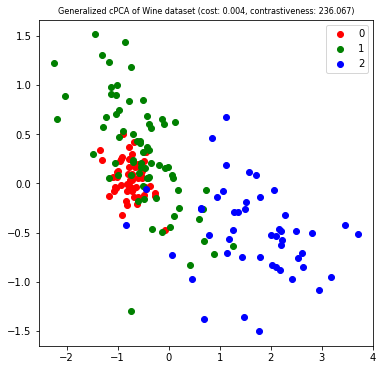

In [8]:
#GCPCA2


GCPCA2 = gen_ldr(gen_cost_gcpca2, gen_default_proj)

y_tg = copy.deepcopy(y)
y_tg[y_tg == 0] = -1
y_bg = copy.deepcopy(y)
y_bg[y_bg == 1] = -1
y_bg[y_bg == 2] = -1
"""
# example 1: LDA
gcpca2 = GCPCA2(n_components=n_components).fit(X,
                                               y_tg=y,
                                               y_bg=y,
                                               y_bw=y,
                                               w_tg=0,
                                               w_bg=1,
                                               w_bw=1)
# example 2: gcPCA
gcpca2 = GCPCA2(n_components=n_components).fit(X,
                                               y_tg=y_tg,
                                               y_bg=y_bg,
                                               y_bw=y,
                                               w_tg=1,
                                               w_bg=1,
                                               w_bw=0)
"""
# example 3: arbitrary weight assignment
w_tg = np.ones(y_tg.shape)
w_bg = np.ones(y_bg.shape)
w_bw = np.ones(y.shape)
w_tg[y_tg == 2] = 5
w_bw[y == 1] = 5
print("w_tg is ")
print(w_tg)
print("w_bg is")
print(w_bg)
print("w_bw")
print(w_bw)
print("y_bw")
print(y)
gcpca2 = GCPCA2(n_components=n_components).fit(X,
                                               y_tg=y_tg,
                                               y_bg=y_bg,
                                               y_bw=y,
                                               w_tg=w_tg,
                                               w_bg=1,
                                               w_bw=0)

Z = gcpca2.transform(X)
cost = gcpca2.get_final_cost()
contrastiveness = 1 / cost

# Plot
plt.figure(figsize=(6, 6))
plt.scatter(Z[y == 0, 0], Z[y == 0, 1], c='r', label=0)
plt.scatter(Z[y == 1, 0], Z[y == 1, 1], c='g', label=1)
plt.scatter(Z[y == 2, 0], Z[y == 2, 1], c='b', label=2)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title(
    f'Generalized cPCA of Wine dataset (cost: {cost:.3f}, contrastiveness: {contrastiveness:.3f})',
    fontsize=8)